### map initialization 

In [1]:
import matplotlib.pyplot as plt 
from munch import munchify
import numpy as np 
import torch 
import open3d as o3d 
import cv2

from utils.dataset import load_dataset
from utils.config_utils import load_config
from gaussian_splatting_2d.scene.gaussian_model import GaussianModel
from gaussian_splatting_2d.utils.graphics_utils import getWorld2View2, getProjectionMatrix2, BasicPointCloud
from utils.camera_utils import Camera
from gaussian_splatting_2d.gaussian_renderer import render
from utils.slam_utils import get_loss_mapping
from utils.logging_utils import Log
from utils.pose_utils import SE3_exp

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


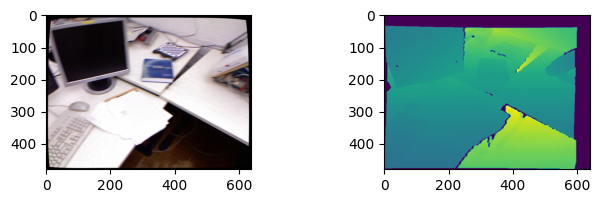

In [2]:
config  = load_config("configs/rgbd/tum/fr1_desk.yaml")
dataset = load_dataset(args=None, path=None, config=config) 

image, depth, _ = dataset[0]
plt.figure(figsize=(8, 2))
plt.subplot(121); plt.imshow(image.permute(1, 2, 0).detach().cpu())
plt.subplot(122); plt.imshow(depth)
plt.show()

In [3]:
# create point cloud from image and depth
def create_pcd_from_image_and_depth(cam, rgb, depth, init=False):

    image_ab = (torch.exp(cam.exposure_a)) * cam.original_image + cam.exposure_b
    image_ab = torch.clamp(image_ab, 0.0, 1.0)
    rgb_raw = (image_ab * 255).byte().permute(1, 2, 0).contiguous().cpu().numpy()

    rgb = o3d.geometry.Image(rgb_raw.astype(np.uint8))
    depth = o3d.geometry.Image(depth.astype(np.float32))

    if init:
        downsample_factor = config["Dataset"]["pcd_downsample_init"]
    else:
        downsample_factor = config["Dataset"]["pcd_downsample"]
            
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb,
        depth,
        depth_scale=1.0,
        depth_trunc=100.0,
        convert_rgb_to_intensity=False,
    )

    W2C = getWorld2View2(cam.R, cam.T).cpu().numpy()
    pcd_tmp = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            cam.image_width,
            cam.image_height,
            cam.fx,
            cam.fy,
            cam.cx,
            cam.cy,
        ),
        extrinsic=W2C,
        project_valid_depth_only=True,
    )
    pcd_tmp = pcd_tmp.random_down_sample(1.0 / downsample_factor)
    new_xyz = np.asarray(pcd_tmp.points)
    new_rgb = np.asarray(pcd_tmp.colors)

    pcd = BasicPointCloud(
        points=new_xyz, colors=new_rgb, normals=np.zeros((new_xyz.shape[0], 3))
    )
    return pcd

projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)
viewpoint         = Camera.init_from_dataset(dataset=dataset, idx=0, projection_matrix=projection_matrix)
viewpoint.update_RT(viewpoint.R_gt, viewpoint.T_gt)

pcd = create_pcd_from_image_and_depth(viewpoint, image, depth, init=True)

# create gaussians from pcd 
spatial_lr_space = dataset.scene_info["nerf_normalization"]["radius"]
opt_params       = munchify(config["opt_params"])
gaussians        = GaussianModel(sh_degree=2, config=config)
gaussians.training_setup(opt_params)
gaussians.extend_from_pcd_seq(cam_info=viewpoint, kf_id=0, init=True, depthmap=viewpoint.depth)

Number of points at initialisation :  7974


In [4]:
point_cloud = o3d.geometry.PointCloud()  
point_cloud.points = o3d.utility.Vector3dVector(pcd.points)
point_cloud.colors = o3d.utility.Vector3dVector(pcd.colors)

# Visualize the point cloud
o3d.visualization.draw_geometries([point_cloud])

In [5]:
# now lets initialize the map 
iteration_count      = 0
init_itr_num         = config["Training"]["init_itr_num"]
init_gaussian_update = config["Training"]["init_gaussian_update"]
init_gaussian_th     = config["Training"]["init_gaussian_th"]
init_gaussian_extent = config["Training"]["init_gaussian_reset"]
init_gaussian_reset  = config["Training"]["init_gaussian_reset"]
pipeline_params      = munchify(config["pipeline_params"])
background           = torch.tensor([0.0, 0.0, 0.0], device="cuda:0")

for mapping_iteration in range(init_itr_num):

    iteration_count += 1
    render_pkg = render(
        viewpoint, gaussians, pipeline_params, background
    )
    (
        image,
        viewspace_point_tensor,
        visibility_filter,
        radii,
        depth,
        opacity
    ) = (
        render_pkg["render"],
        render_pkg["viewspace_points"],
        render_pkg["visibility_filter"],
        render_pkg["radii"],
        render_pkg["surf_depth"],
        render_pkg["rend_alpha"]
    )
    loss_init = get_loss_mapping(
            config, image, depth, viewpoint, opacity, initialization=True
    )
    loss_init.backward()

    with torch.no_grad():
        # update max radii, eventually decides to prune big splats 
        gaussians.max_radii2D[visibility_filter] = torch.max(
            gaussians.max_radii2D[visibility_filter],
            radii[visibility_filter],
        )
        #accumulates position gradient 
        gaussians.add_densification_stats(
            viewspace_point_tensor, visibility_filter
        )
        # densify and prune accordingly 
        if mapping_iteration % init_gaussian_update == 0:
            gaussians.densify_and_prune(
                opt_params.densify_grad_threshold,
                init_gaussian_th,
                init_gaussian_extent,
                None,
            )
        # reset opacity 
        if iteration_count == init_gaussian_reset or (
            iteration_count == opt_params.densify_from_iter
                ):
            gaussians.reset_opacity()

        gaussians.optimizer.step()
        gaussians.optimizer.zero_grad(set_to_none=True)

        #self.occ_aware_visibility[cur_frame_idx] = (n_touched > 0).long() <---- occlusion information 
Log("Initialized map")

MonoGS: Initialized map

In [6]:
print("number of gaussians: ", len(gaussians._xyz))

number of gaussians:  17644


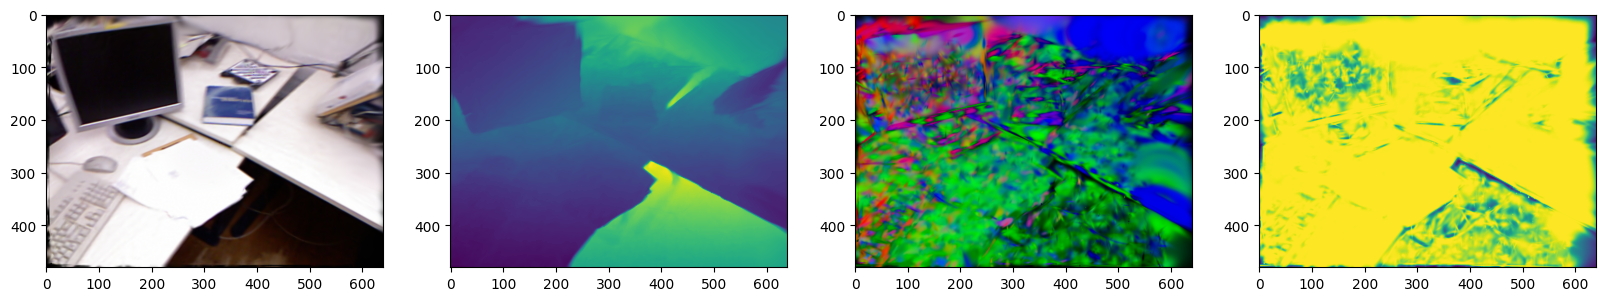

In [7]:
normal = torch.clamp(render_pkg["rend_normal"], 0, 1)
image = torch.clamp(image, 0, 1)

plt.figure(figsize=(20, 4))
plt.subplot(141); plt.imshow(image.permute(1, 2, 0).detach().cpu())
plt.subplot(142); plt.imshow(depth.squeeze().detach().cpu())
plt.subplot(143); plt.imshow(normal.permute(1, 2, 0).detach().cpu())
plt.subplot(144); plt.imshow(opacity.squeeze().detach().cpu())
plt.show()

In [29]:
def mat2quat(R):
    trace = torch.trace(R)

    if trace > 0:
        S = 2.0 * torch.sqrt(trace + 1.0)
        q_w = 0.25 * S
        q_x = (R[2, 1] - R[1, 2]) / S
        q_y = (R[0, 2] - R[2, 0]) / S
        q_z = (R[1, 0] - R[0, 1]) / S
    elif (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
        S = 2.0 * torch.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
        q_w = (R[2, 1] - R[1, 2]) / S
        q_x = 0.25 * S
        q_y = (R[0, 1] + R[1, 0]) / S
        q_z = (R[0, 2] + R[2, 0]) / S
    elif R[1, 1] > R[2, 2]:
        S = 2.0 * torch.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
        q_w = (R[0, 2] - R[2, 0]) / S
        q_x = (R[0, 1] + R[1, 0]) / S
        q_y = 0.25 * S
        q_z = (R[1, 2] + R[2, 1]) / S
    else:
        S = 2.0 * torch.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
        q_w = (R[1, 0] - R[0, 1]) / S
        q_x = (R[0, 2] + R[2, 0]) / S
        q_y = (R[1, 2] + R[2, 1]) / S
        q_z = 0.25 * S

    return torch.tensor([q_w, q_x, q_y, q_z])
def quadmultiply(q1, q2):
    """
    Multiply two quaternions together using quaternion arithmetic
    """
    # Extract scalar and vector parts of the quaternions
    w1, x1, y1, z1 = q1.unbind(dim=-1)
    w2, x2, y2, z2 = q2.unbind(dim=-1)
    # Calculate the quaternion product
    result_quaternion = torch.stack(
        [
            w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
            w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
            w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
            w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2,
        ],
        dim=-1,
    )

    return result_quaternion

gaussians._rotation.shape

torch.Size([17329, 4])

In [30]:
from utils.pose_utils import update_pose

tau = torch.cat([viewpoint.cam_trans_delta, viewpoint.cam_rot_delta], axis=0)

T_w2c = torch.eye(4, device=tau.device)
T_w2c[0:3, 0:3] = viewpoint.R
T_w2c[0:3, 3] = viewpoint.T
new_w2c = SE3_exp(tau) @ T_w2c

points_hom = torch.cat([gaussians._xyz, torch.ones(gaussians._xyz.shape[0], 1, device="cuda")], dim=1)
points_trans =(new_w2c @ points_hom.T).T
rot_trans = quadmultiply(mat2quat(new_w2c[:3, :3]), gaussians._rotation)


In [8]:
# transform view 
from utils.pose_utils import update_pose
from utils.slam_utils import get_loss_tracking

update_pose(viewpoint)
viewpoint.compute_grad_mask(config)
opt_params = []
opt_params.append(
            {
                "params": [viewpoint.cam_rot_delta],
                "lr": config["Training"]["lr"]["cam_rot_delta"],
                "name": "rot_{}".format(viewpoint.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint.cam_trans_delta],
                "lr": config["Training"]["lr"]["cam_trans_delta"],
                "name": "trans_{}".format(viewpoint.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint.exposure_a],
                "lr": 0.01,
                "name": "exposure_a_{}".format(viewpoint.uid),
            }
        )
opt_params.append(
            {
                "params": [viewpoint.exposure_b],
                "lr": 0.01,
                "name": "exposure_b_{}".format(viewpoint.uid),
            }
        )

pose_optimizer = torch.optim.Adam(opt_params)

render_ex = render(
        viewpoint, gaussians, pipeline_params, background
)
(
        image,
        viewspace_point_tensor,
        visibility_filter,
        radii,
        depth,
        opacity
    ) = (
        render_pkg["render"],
        render_pkg["viewspace_points"],
        render_pkg["visibility_filter"],
        render_pkg["radii"],
        render_pkg["surf_depth"],
        render_pkg["rend_alpha"]
    )

pose_optimizer.zero_grad()
loss_tracking = get_loss_tracking(
    config, image, depth, opacity, viewpoint
)

loss_tracking.backward()

print("grad delta rotacional", viewpoint.cam_rot_delta.grad)
print("grad delta translacional", viewpoint.cam_trans_delta.grad)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

### superpixels 

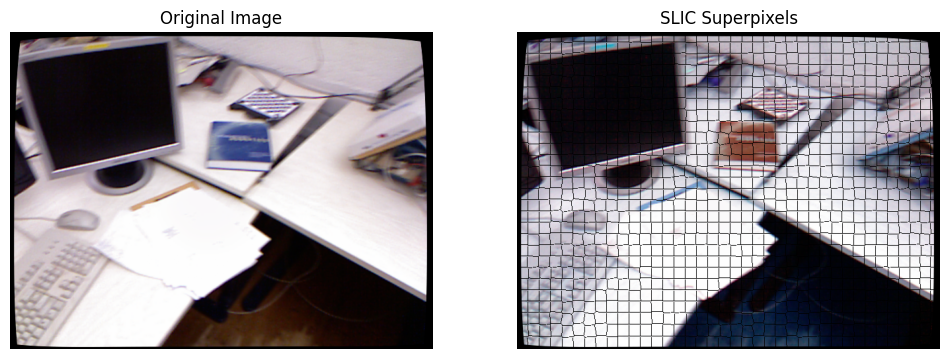

In [11]:
# Load the image
image, _, _ = dataset[0]
image = image.permute(1, 2, 0).cpu().numpy()

# Initialize SLIC algorithm with the desired parameters
num_superpixels = 1000      # The number of superpixels you want
compactness     = 10       # Controls the compactness (color vs. spatial proximity)

# Create a SLIC superpixel segmenter
slic = cv2.ximgproc.createSuperpixelSLIC(image, algorithm=cv2.ximgproc.SLIC, region_size=int(np.sqrt(image.shape[0] * image.shape[1] / num_superpixels)), ruler=compactness)

# Run SLIC
slic.iterate(10)  # Number of iterations

# Get the mask (boundary of superpixels)
mask_slic  = slic.getLabelContourMask()
label_slic = slic.getLabels()               # Get the label matrix for each superpixel
num_slic   = slic.getNumberOfSuperpixels()  # Get the actual number of superpixels

# Create an overlay to visualize superpixel boundaries
mask_inv         = cv2.bitwise_not(mask_slic)
image_superpixel = cv2.bitwise_and(image, image, mask=mask_inv)

# Convert to RGB for plotting
image_superpixel_rgb = cv2.cvtColor(image_superpixel, cv2.COLOR_BGR2RGB)

# Plot original and SLIC superpixels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(image_superpixel_rgb)
ax2.set_title("SLIC Superpixels")
ax2.axis("off")
plt.show()


In [38]:
#plt.imshow((viewpoint.original_image ** 2).permute(1, 2, 0).detach().cpu())
viewpoint.depth

array([[0.    , 1.4686, 1.4686, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.7378, 0.7398, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]])

In [29]:
x = torch.tensor([1, 1, 1], dtype=float, requires_grad=True)
y = torch.linalg.norm(x) ** 2
y.backward()
print(x.grad)

tensor([2., 2., 2.], dtype=torch.float64)
